## Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import os.path as osp
import pandas as pd
import pydicom as dicom
from torchsummary import summary
import time

In [2]:
torch.__version__

'1.10.0'

## Setting file and directory paths

In [3]:
top_root_dir = r"I:\New folder"
csv_filename = 'files_and_labels.csv'

## Inspecting the data

In [28]:
img_df = pd.read_csv(osp.join(top_root_dir, csv_filename))
img_df

,file,label,subject_id
0,I:\New folder\MPRAGE2\ADNI\002_S_0295\MP-RAGE_...,CN,002_S_0295
1,I:\New folder\MPRAGE2\ADNI\002_S_0295\MP-RAGE_...,CN,002_S_0295
2,I:\New folder\MPRAGE2\ADNI\002_S_0295\MP-RAGE_...,CN,002_S_0295
3,I:\New folder\MPRAGE2\ADNI\002_S_0295\MP-RAGE_...,CN,002_S_0295
4,I:\New folder\MPRAGE2\ADNI\002_S_0295\MP-RAGE_...,CN,002_S_0295
...,...,...,...
192240,I:\New folder\MPRAGE2\ADNI\941_S_6854\Accelera...,AD,941_S_6854
192241,I:\New folder\MPRAGE2\ADNI\941_S_6854\Accelera...,AD,941_S_6854
192242,I:\New folder\MPRAGE2\ADNI\941_S_6854\Accelera...,AD,941_S_6854
192243,I:\New folder\MPRAGE2\ADNI\941_S_6854\Accelera...,AD,941_S_6854


## The counts for all labels

In [29]:
img_df['label'].value_counts()

MCI        60150
CN         58260
EMCI       29257
AD         25106
LMCI       14697
SMC         4724
Patient       51
Name: label, dtype: int64

## The dataset class for DataLoader

In [7]:
class MRIDataset(Dataset):
    def __init__(self, annotations_file, root_dir, transform=None, target_transform=None):
        self.img_df = pd.read_csv(annotations_file)
        
        ### limiting the size for now
        k = []
        for i in range(0,500):
            k.append(i)
        for i in range(20000, 20500):
            k.append(i)
        self.img_df = self.img_df.iloc[k]
        ######
        
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        self.unique_labels = ['MCI', 'CN', 'EMCI', 'AD', 'LMCI', 'SMC', 'Patient']

    def __len__(self):
        return len(self.img_df)

    def __getitem__(self, idx):
        dcm_filename = self.img_df.iloc[idx]['file']
        label = self.img_df.iloc[idx]['label']
        label = self.unique_labels.index(label)
        
        subject_id = self.img_df.iloc[idx]['subject_id']
        
        ds = dicom.dcmread(dcm_filename)
        image = np.array(ds.pixel_array)
        
        # For CARC
        #image = image.astype('float32')
        image = image.astype('float')
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [8]:
top_root_dir = r"I:\New folder"
csv_filename = 'files_and_labels.csv'

csv_file = osp.join(top_root_dir, csv_filename)
img_dataset = MRIDataset(csv_file, top_root_dir)
print(f"Number of samples: {len(img_dataset)}")

Number of samples: 1000


In [9]:
#for i in range(len(img_dataset)):
#    if img_dataset[i][0].shape != (1, 256, 256):
#        print(i, img_dataset[i][0].shape)

In [10]:
print(img_dataset[49])

(array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 1)


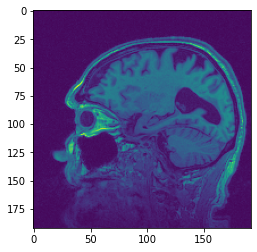

In [11]:
plt.imshow(img_dataset[596][0])
plt.show()

In [12]:
img_dataset[0][0].shape

(256, 256)

## Transformation

In [13]:
class ToTensor(object):
    def __call__(self, image):
        image = torch.from_numpy(image)
        image = torch.unsqueeze(image, 0)

        return image

## Setting up DataLoader

In [ ]:
# For CARC
transformed_dataset = MRIDataset(csv_file, 
                                 top_root_dir, 
                                 transforms.Compose([transforms.ToPILImage(),
                                                     transforms.Resize((192, 192)),
                                                     transforms.ToTensor()]))

In [14]:
transformed_dataset = MRIDataset(csv_file, 
                                 top_root_dir, 
                                 transforms.Compose([ToTensor(), 
                                                     transforms.Resize((192, 192))]))

In [15]:
transformed_dataset[0][0].shape

torch.Size([1, 192, 192])

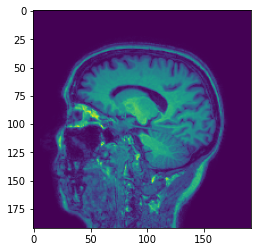

In [16]:
plt.imshow(transformed_dataset[249][0][0].numpy())
plt.show()

In [17]:
#for i in range(len(transformed_dataset)):
#    if transformed_dataset[i][0].shape != transformed_dataset[0][0].shape:
#        print(i, transformed_dataset[i][0].shape)

## Splitting data into training and validation set

In [18]:
# define the train and val splits
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT

#print(len(transformed_dataset))

# calculate the train/validation split
num_train_samples = int(len(transformed_dataset) * TRAIN_SPLIT)
#print(num_train_samples)
num_val_samples = int(len(transformed_dataset) * VAL_SPLIT)
#print(num_val_samples)

(train_data, val_data) = random_split(transformed_dataset,
                                    [num_train_samples, num_val_samples],
                                    generator=torch.Generator().manual_seed(42))

In [19]:
batch_size=16
train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
val_data_loader = DataLoader(val_data, batch_size=batch_size, num_workers=0)

In [20]:
for index, sample_batch in enumerate(train_data_loader):
    print(index, sample_batch[0].size(), sample_batch[1].size())
    print(sample_batch[1])
    #print(sample_batch)
    
    if index == 5:
        break

0 torch.Size([16, 1, 192, 192]) torch.Size([16])
tensor([3, 1, 1, 0, 1, 1, 1, 3, 1, 1, 3, 1, 1, 0, 1, 1])
1 torch.Size([16, 1, 192, 192]) torch.Size([16])
tensor([3, 3, 0, 0, 1, 1, 3, 1, 1, 1, 3, 3, 1, 0, 0, 1])
2 torch.Size([16, 1, 192, 192]) torch.Size([16])
tensor([1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 3, 1, 0])
3 torch.Size([16, 1, 192, 192]) torch.Size([16])
tensor([3, 3, 1, 1, 1, 3, 1, 3, 3, 1, 1, 1, 3, 0, 1, 3])
4 torch.Size([16, 1, 192, 192]) torch.Size([16])
tensor([0, 1, 0, 0, 1, 1, 3, 1, 3, 3, 0, 3, 1, 3, 3, 1])
5 torch.Size([16, 1, 192, 192]) torch.Size([16])
tensor([3, 0, 0, 1, 0, 3, 3, 1, 0, 1, 0, 0, 3, 3, 1, 1])


## CUDA

In [21]:
#Instantiating CUDA device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#Verifying CUDA
print(device)
print(torch.cuda.device_count())

cpu
0


## Architecture of the 2D CNN model
AlexNet structure but training weights and biases from scratch

In [22]:
class CNN(nn.Module):
    def __init__(self, num_classes, dropout):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            
            nn.Linear(4096, num_classes),
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
model = CNN(num_classes = 7, dropout = 0.5).to(device)

In [23]:
summary(model, input_size=(1, 192, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 47, 47]           7,808
              ReLU-2           [-1, 64, 47, 47]               0
         MaxPool2d-3           [-1, 64, 23, 23]               0
            Conv2d-4          [-1, 192, 23, 23]         307,392
              ReLU-5          [-1, 192, 23, 23]               0
         MaxPool2d-6          [-1, 192, 11, 11]               0
            Conv2d-7          [-1, 384, 11, 11]         663,936
              ReLU-8          [-1, 384, 11, 11]               0
            Conv2d-9          [-1, 256, 11, 11]         884,992
             ReLU-10          [-1, 256, 11, 11]               0
           Conv2d-11          [-1, 256, 11, 11]         590,080
             ReLU-12          [-1, 256, 11, 11]               0
        MaxPool2d-13            [-1, 256, 5, 5]               0
AdaptiveAvgPool2d-14            [-1, 25

In [24]:
#Loss
loss_fn = nn.CrossEntropyLoss()

#Optimizer(SGD)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [26]:
epochs = 12
size = len(train_data_loader.dataset)

train_loss = []
val_loss = []
train_acc = []
val_acc = []

# timer starts
start = time.perf_counter()

for epoch in range(epochs):
    #i_batch, sample_batched
    for batch, (x,y) in enumerate(train_data_loader):
        model.train()

        # Transfer data to device
        x, y = x.to(device, dtype=torch.float32), y.to(device) 

        # Pass data through model
        y_pred = model(x)

        # Calculate loss 
        loss = loss_fn(y_pred, y)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            # Calculate accuracy 
            acc = (y_pred.argmax(1) == y).type(torch.float)
            acc = torch.mean(acc)

            # Append to lists 
            train_loss.append(loss.item())
            train_acc.append(acc.item())
    
            # Do validation
            validation_loss, validation_acc = validation(val_data_loader, model, loss_fn)
            val_loss.append(validation_loss)
            val_acc.append(validation_acc)
    
    # Log some info
    loss, current = loss.item(), batch * len(x)
    print(f"Epoch = {epoch}, train loss: {loss:>7f}, train accuracy: {acc}")
    

# timer ends
end = time.perf_counter()
elapsed_time = end - start
print(f"Elapsed time: {elapsed_time}")

Epoch = 0, train loss: 0.945652, train accuracy: 0.5625
Epoch = 1, train loss: 0.596627, train accuracy: 0.75
Epoch = 2, train loss: 0.178535, train accuracy: 0.75
Epoch = 3, train loss: 0.221793, train accuracy: 0.75
Epoch = 4, train loss: 0.218328, train accuracy: 0.875
Epoch = 5, train loss: 0.007137, train accuracy: 1.0
Epoch = 6, train loss: 0.000218, train accuracy: 1.0
Epoch = 7, train loss: 0.000397, train accuracy: 1.0
Epoch = 8, train loss: 0.004657, train accuracy: 1.0
Epoch = 9, train loss: 0.000438, train accuracy: 1.0
Epoch = 10, train loss: 0.000160, train accuracy: 1.0
Epoch = 11, train loss: 0.000142, train accuracy: 1.0
Elapsed time: 4985.652634338


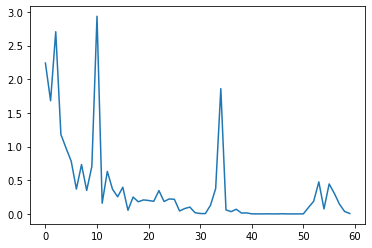

In [22]:
plt.plot(train_loss)
plt.show()

In [25]:
# Aux function that runs validation and returns val loss/acc
def validation(dataloader, model, loss_fn):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model.eval() # Set the model on inference mode; dropout
    loss, accuracy = [], []
    with torch.no_grad(): # no_grad() skips the gradient computation; faster
        for i, (X,y) in enumerate(dataloader):
            X, y = X.to(device, dtype=torch.float), y.to(device)
            pred = model(X)
            loss.append(loss_fn(pred, y).item())
            accuracy.append((pred.argmax(1) == y).type(torch.float).sum().item() / y.shape[0] )
            if i == 20:
                break

    # Avg loss/acc accross
    loss = np.mean(loss)
    accuracy = np.mean(accuracy)
    return loss, accuracy


def plot(train_loss, val_loss, train_acc, val_acc, title=""): 
    fig, ax = plt.subplots(1,2,figsize=(12,6))
    ax[0].plot(train_loss)
    ax[0].set_xlabel("iteration")
    ax[0].set_ylabel("loss")

    ax[0].plot(val_loss)
    ax[0].set_xlabel("iteration")
    ax[0].set_ylabel("loss")
    ax[0].legend(["train", "validation"])

    ax[1].plot(train_acc)
    ax[1].set_xlabel("iteration")
    ax[1].set_ylabel("accuracy")

    ax[1].plot(val_acc)
    ax[1].set_xlabel("iteration")
    ax[1].set_ylabel("accuracy")
    ax[0].legend(["train", "validation"])
    if title:
        fig.suptitle(title)


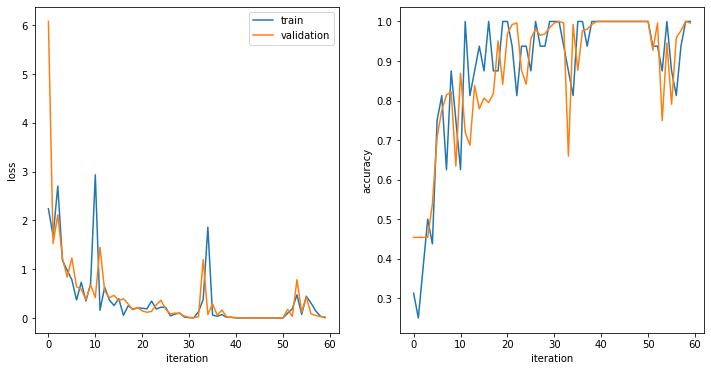

In [23]:
# Plot the train/val loss and accuracy unnormalized data
plot(train_loss, val_loss, train_acc, val_acc, "")

## Saving the model

In [26]:
torch.save(model.state_dict(), 'model.pth')